# Описание проекта

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Описание данных

Технологический процесс

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate **— ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота


Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Возможные значения для блока [тип_параметра]:

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики


# 1. Подготовка данных

In [431]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split #импортируем функцию train_test_split из библиотеки sklearn 

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

In [432]:
train=pd.read_csv("/datasets/gold_recovery_train.csv") #прочитаем файл с обучающей выборкой
test=pd.read_csv("/datasets//gold_recovery_test.csv") #прочитаем файл с  тестовой выборкой
full=pd.read_csv("/datasets/gold_recovery_full.csv") #прочитаем файл с исходными данными

In [433]:
train.info() # изучим общую информацию по дата фрейму

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [434]:
#train.head(100)

In [435]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [436]:
#test.head(30)

In [437]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [438]:
#full.head(30)

In [439]:
#Проверим, что эффективность обогащения рассчитана правильно. 
#Вычислим её на обучающей выборке для признака rougher.output.recovery.  
def effectivity(df):
    C = df['rougher.output.concentrate_au']
    F=df['rougher.input.feed_au']
    T=df['rougher.output.tail_au']
    try:
        recovery = (C*(F-T))/(F*(C-T))*100
        return recovery
    except:
        return np.nan

In [440]:
#Удалим все строчки с Nan, так как их нельзя заменять на какое-либо статистическое значение.
train=train.dropna()

In [441]:
len(train)

11017

In [442]:
test=test.dropna()

In [443]:
len(test)

5383

In [444]:
full=full.dropna()

In [445]:
len(full)

16094

In [446]:
print(effectivity(train).describe())

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
dtype: float64


In [447]:
train['rougher.output.recovery'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [448]:
#Найдем MAE между нашими расчётами и значением признака rougher.output.recovery.  
mae='{:.20f}'.format(mean_absolute_error(effectivity(train),train['rougher.output.recovery']))
print("MAE", mae)

MAE 0.00000000000000955560


In [449]:
##сменим тип данных на дату
#train['date']=pd.to_datetime(train['date'], format="%Y-%m-%d %H:%M:%S")
#test['date']=pd.to_datetime(test['date'], format="%Y-%m-%d %H:%M:%S")
#full['date']=pd.to_datetime(full['date'], format="%Y-%m-%d %H:%M:%S")

In [450]:
#проверим, изменился ли тип
#train.info()

In [451]:
columns_train=set(train.columns)
columns_test=set(test.columns)
#найдем каких столбцов нет в тестовой выборке
col=columns_train-columns_test

In [452]:
col

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

# Вывод: 
Данные прошли предобработку. Добалили необходимые библиотеки, изучили общую информацию по датафрейму.
16860 в обучающей выборке, 5856 в тестовой, 22716 в общей выборке. После удаления пропусков 11017 в обучающей сократили почти на 35%, 5383 в тестовой на 9%, в общей 16094 на 30%.

Средняя относительная ошибка между нашими расчётами и значением признака эффективности обогащения  rougher.output.recovery равна 0.00000000000000955560, что говорит о том, что эффективность обогащения рассчитана правильно. 

В тестовой выборке недоступны данные этапа final, тип параметры продукта и другие данные, потому что замеряются и/или рассчитываются значительно позже.

Средняя абсолютная ошибка MAE=$9.6\cdot 10^{-15}$ найдена верно, значит, формула для расчета эффективности корректная и доступные данные ее подтверждают. 

# 2. Анализ данных

In [453]:
#2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
full_au=train.filter(regex='concentrate_au',axis=1)

In [454]:
full_au

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
0,42.192020,34.174427,19.793808
1,42.701629,34.118526,20.050975
2,42.657501,33.969464,19.737170
3,42.689819,28.260743,19.320810
4,42.774141,33.044932,19.216101
...,...,...,...
16855,46.713954,32.940215,18.603550
16856,46.866780,32.925325,18.441436
16857,46.795691,31.856742,15.111231
16858,46.408188,30.770892,17.834772


Диаграмма размаха концентрации AU на различных этапах очистки


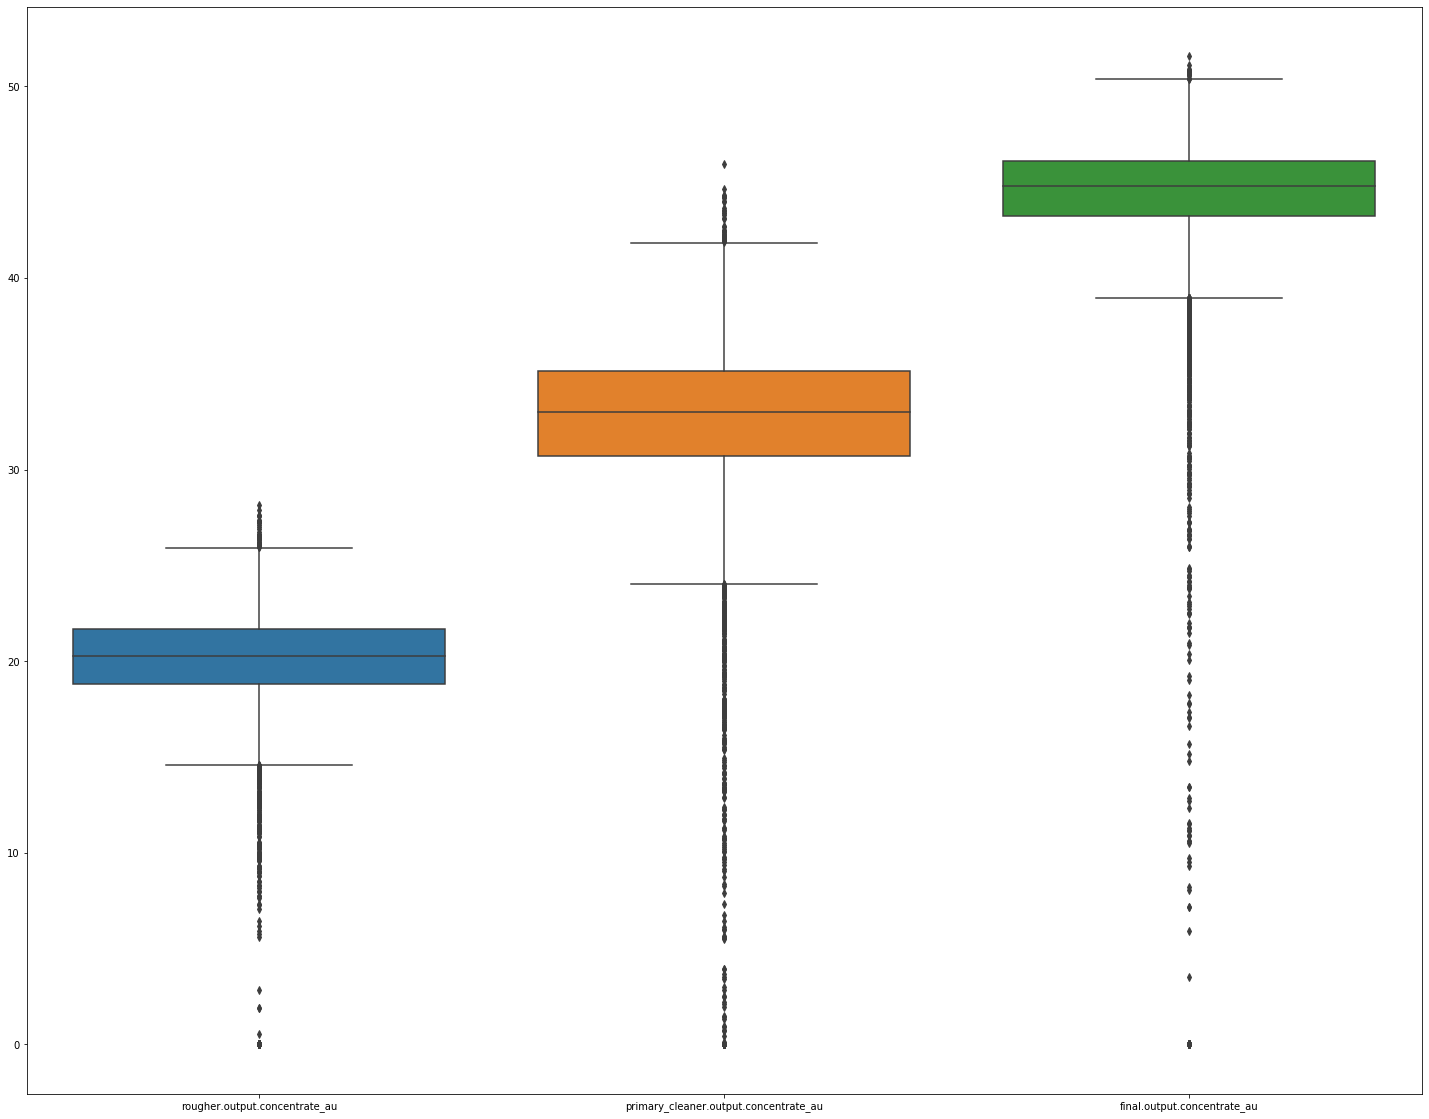

In [455]:
print("Диаграмма размаха концентрации AU на различных этапах очистки")
plt.figure(figsize=(25,20)) 
sns.boxplot(data=full_au[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']])

In [456]:
full_ag=train.filter(regex='concentrate_ag',axis=1)

In [457]:
full_ag

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag
0,6.055403,8.547551,11.500771
1,6.029369,8.558743,11.615865
2,6.055926,8.603505,11.695753
3,6.047977,7.221879,11.915047
4,6.148599,9.089428,12.411054
...,...,...,...
16855,3.224920,6.559174,11.124896
16856,3.195978,6.612376,11.425983
16857,3.109998,7.128896,8.523497
16858,3.367241,7.490444,11.658799


Диаграмма размаха концентрации AG на различных этапах очистки


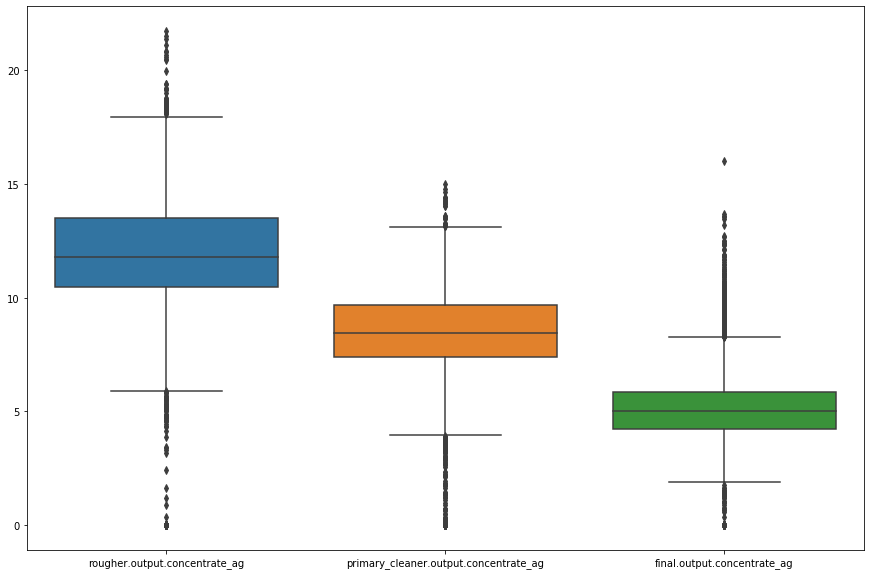

In [458]:
print("Диаграмма размаха концентрации AG на различных этапах очистки")
plt.figure(figsize=(15,10)) 
sns.boxplot(data=full_ag[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']])

In [459]:
full_pb=train.filter(regex='concentrate_pb',axis=1)

In [460]:
full_pb

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb
0,9.889648,10.389648,7.101074
1,9.968944,10.497069,7.278807
2,10.213995,10.354494,7.216833
3,9.977019,8.496563,7.175616
4,10.142511,9.986786,7.240205
...,...,...,...
16855,11.356233,12.445966,10.984003
16856,11.349355,12.623947,10.888213
16857,11.434366,12.633558,8.955135
16858,11.625587,12.012378,10.655377


Диаграмма размаха концентрации PB на различных этапах очистки


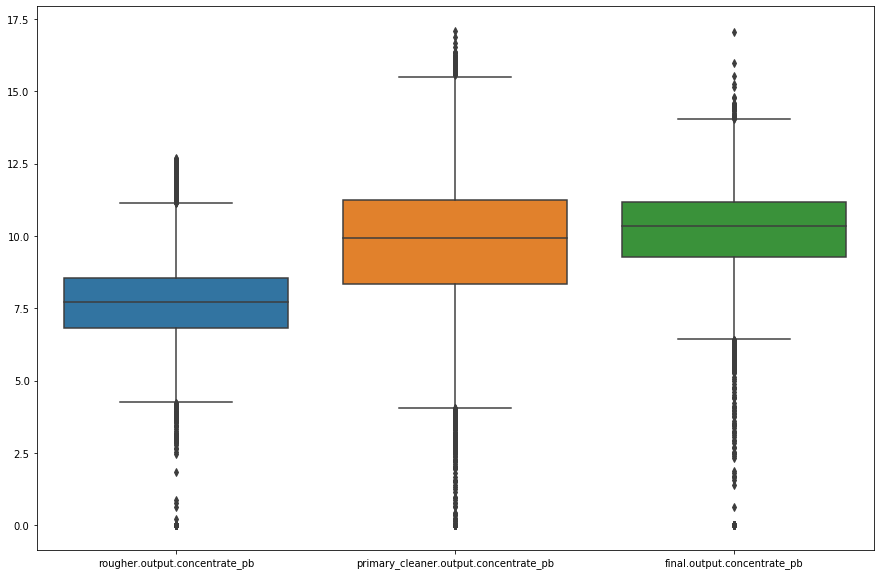

In [461]:
print("Диаграмма размаха концентрации PB на различных этапах очистки")
plt.figure(figsize=(15,10)) 
sns.boxplot(data=full_pb[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']])


##Вывод: 
Концентрация AU, PB после каждого этапа очистки растет, а у AG концентрация после каждого этапа снижается.

In [462]:
#2.2  Сравним распределения размеров гранул сырья на обучающей и тестовой выборках
train_feed_size=train.filter(regex='feed_size',axis=1) 
test_feed_size=test.filter(regex='feed_size',axis=1) 
both=pd.concat([train_feed_size,test_feed_size], axis=1)

In [463]:
train_feed_size

,primary_cleaner.input.feed_size,rougher.input.feed_size
0,7.25,55.486599
1,7.25,57.278666
2,7.25,57.510649
3,7.25,57.792734
4,7.25,56.047189
...,...,...
16855,6.50,85.718304
16856,6.50,119.499241
16857,6.50,122.262690
16858,6.50,123.742430


In [464]:
test_feed_size

,primary_cleaner.input.feed_size,rougher.input.feed_size
0,8.080000,62.710452
1,8.080000,61.961163
2,7.786667,66.903807
3,7.640000,59.865919
4,7.530000,63.315324
...,...,...
5851,8.070000,66.758479
5852,8.070000,62.560684
5853,8.070000,73.647513
5854,8.070000,78.066446


In [465]:
both.columns=['train_primary_cleaner.input.feed_size','train_rougher.input.feed_size','test_primary_cleaner.input.feed_size','test_rougher.input.feed_size']

In [466]:
%matplotlib inline

Диаграмма распределения размеров гранул сырья на черновом этапе очистки по обучающей и тестовой выборке


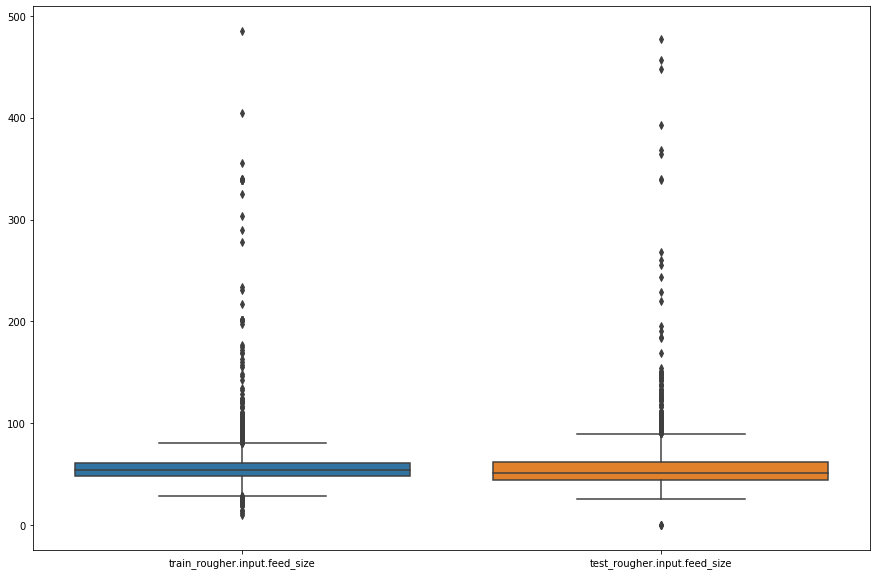

In [467]:
print("Диаграмма распределения размеров гранул сырья на черновом этапе очистки по обучающей и тестовой выборке")
plt.figure(figsize=(15,10)) 
sns.boxplot(data=both[['train_rougher.input.feed_size','test_rougher.input.feed_size']])

Диаграмма распределения размеров гранул сырья на этапе первой очистки по обучающей и тестовой выборке


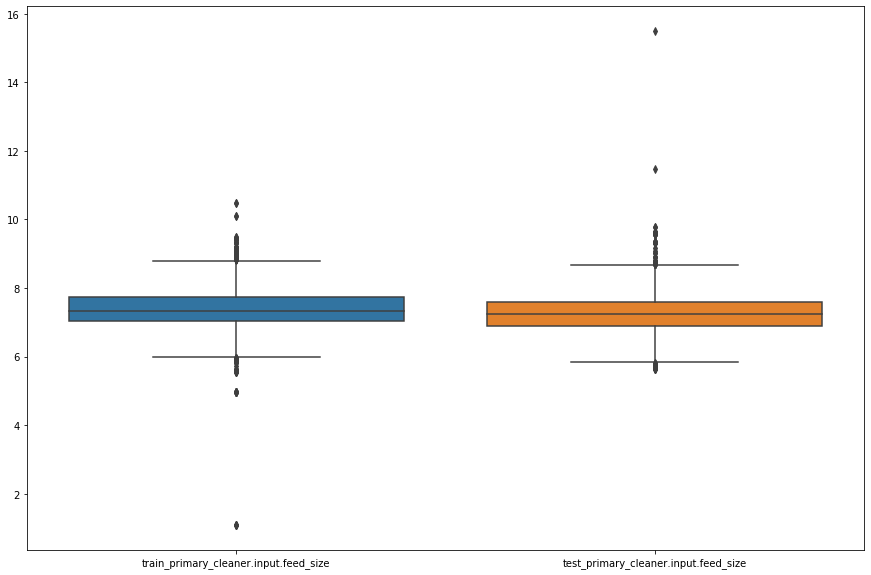

In [468]:
print("Диаграмма распределения размеров гранул сырья на этапе первой очистки по обучающей и тестовой выборке")
plt.figure(figsize=(15,10)) 
sns.boxplot(data=both[['train_primary_cleaner.input.feed_size','test_primary_cleaner.input.feed_size']])

In [469]:
train_feed_size.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,11017.000000,11017.000000
mean,7.396036,57.215128
std,0.575317,18.913146
min,1.080000,9.659576
25%,7.030000,48.397242
50%,7.323334,53.843359
75%,7.740000,61.461770
max,10.470000,484.967466


In [470]:
test_feed_size.describe()

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,5383.000000,5383.000000
mean,7.268670,56.338644
std,0.610441,21.836788
min,5.650000,0.046369
25%,6.892500,43.913766
50%,7.250000,50.924232
75%,7.600000,62.364984
max,15.500000,477.445473


Вывод: Распределения незначительно отличаются друг от друга.

# 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [471]:
train["rougher_sum"]=train["rougher.output.concentrate_ag"]+train["rougher.output.concentrate_pb"]+train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au']  
train["primary_sum"]=train["primary_cleaner.output.concentrate_ag"]+train["primary_cleaner.output.concentrate_pb"]+train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au']  
train["final_sum"]=train["final.output.concentrate_ag"]+train["final.output.concentrate_pb"]+train['final.output.concentrate_sol']+train['final.output.concentrate_au']  

In [472]:
train["rougher_sum"].describe()

count    11017.000000
mean        67.898765
std         12.244650
min          0.000000
25%         65.471243
50%         69.701409
75%         73.921804
max         87.273435
Name: rougher_sum, dtype: float64

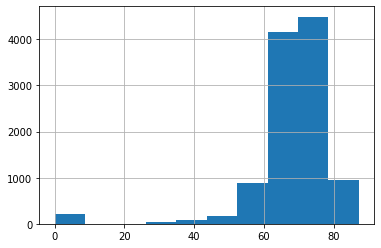

In [473]:
train["rougher_sum"].hist()

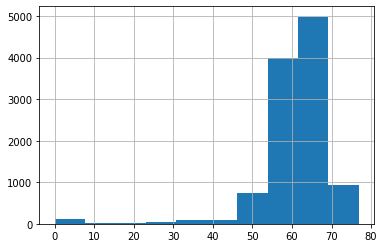

In [474]:
train["primary_sum"].hist()

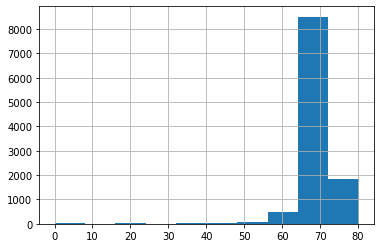

In [475]:
train["final_sum"].hist()

In [476]:
test['input_sum']=test['rougher.input.feed_ag']+test['rougher.input.feed_pb']+test['rougher.input.feed_sol']+test['rougher.input.feed_au']  

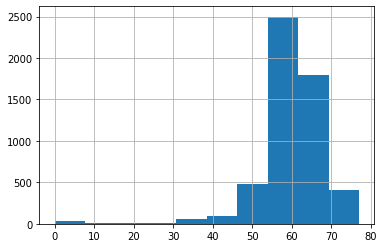

In [477]:
test['input_sum'].hist()

Вывод: Наблюдаются аномальные значения в суммарном распределении. Их необходимо удалить. Данные по концентрации только в общей и обучающей выборке. Удалим из обеих выборок.

In [478]:
#удалим аномалии из обучающей выборки 

train=train.loc[(train['rougher_sum']>20) & (train['primary_sum']>20) & (train['final_sum']>20)] 

In [479]:
#удалим аномалии из тестовой выборки

test=test.loc[test['input_sum']>20]

# 3. Модель

In [480]:
test=test.merge(full[['date','rougher.output.recovery','final.output.recovery']], on='date', how='left')

In [481]:
test=test.dropna()

Построим модель, которая спрогнозирует сразу две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.


In [482]:
#создадим переменные для признаков и целевого признака rougher.output.recovery для 2х выборок:

#для обучающей
target_train_r = train['rougher.output.recovery']

#отфильтруем по префиксам те признаки, которые относятся у самой первой стадии производства
filt_state=train.filter(regex='^rougher.state',axis=1)
filt_input=train.filter(regex='^rougher.input',axis=1)
 
#признаки для обучающей выборки 
features_train_r =pd.concat([filt_state,filt_input], axis=1)

In [483]:
features_train_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10612 entries, 0 to 16859
Data columns (total 22 columns):
rougher.state.floatbank10_a_air       10612 non-null float64
rougher.state.floatbank10_a_level     10612 non-null float64
rougher.state.floatbank10_b_air       10612 non-null float64
rougher.state.floatbank10_b_level     10612 non-null float64
rougher.state.floatbank10_c_air       10612 non-null float64
rougher.state.floatbank10_c_level     10612 non-null float64
rougher.state.floatbank10_d_air       10612 non-null float64
rougher.state.floatbank10_d_level     10612 non-null float64
rougher.state.floatbank10_e_air       10612 non-null float64
rougher.state.floatbank10_e_level     10612 non-null float64
rougher.state.floatbank10_f_air       10612 non-null float64
rougher.state.floatbank10_f_level     10612 non-null float64
rougher.input.feed_ag                 10612 non-null float64
rougher.input.feed_pb                 10612 non-null float64
rougher.input.feed_rate              

In [484]:
#для тестовой целевой признак

target_test_r=test['rougher.output.recovery']

#отфильтруем по префиксам те признаки, которые относятся у самой первой стадии производства
filt_state_test=test.filter(regex='^rougher.state',axis=1)
filt_input_test=test.filter(regex='^rougher.input',axis=1)
filt_calculation_test=test.filter(regex='^rougher.calculation',axis=1)

#признаки тестовой выборки 
features_test_r =pd.concat([filt_state_test,filt_input_test,filt_calculation_test], axis=1)

In [485]:
features_test_r_columns=list(features_test_r)
features_test_r_columns

['rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [486]:
features_train_r_columns=list(features_train_r)
features_train_r_columns

['rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [487]:
#Произведем масштабирование 
#создадим функцию для масштабирования числовых данных, возвращающую отмасштабированные выборки признаков

def scaler (features_train, features_test,columns):
    numeric = columns
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train,features_test

In [488]:
#применим для тренировочной и тестовой выборок функцию масштабирования
features_train_r,features_test_r=scaler(features_train_r, features_test_r, features_test_r_columns)

In [489]:
#создадим переменные для признаков и целевого признака final.output.recovery для 2х выборок:

#для тестовой
target_test_f = test['final.output.recovery']

#отфильтруем по префиксам те признаки, которые ко всем стадиям кроме финальной
filt_final=test.filter(regex='^final.output',axis=1)
features_test_f=test.drop(filt_final, axis=1).drop(['date'], axis=1).drop(['input_sum'], axis=1).drop(['rougher.output.recovery'], axis=1)

In [490]:
# проверим, соответствуют ли колонки фичам в тестовой выборке

features_test_f=features_test_f.dropna()

In [491]:
columns_features=list(features_test_f.columns)

In [492]:
#для обучающей

target_train_f = train['final.output.recovery']

#отфильтруем по префиксам те признаки, которые относятся у самой первой стадии производства

features_train_f=train[columns_features]

In [493]:
#применим для тренировочной и тестовой выборок функцию масштабирования
features_train_f,features_test_f=scaler(features_train_f, features_test_f, columns_features)

3.1. Напишем функцию для вычисления итоговой sMAPE.

3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. 

In [494]:
#напишем функцию SMAPE
def smape(target,predict):
    try:
        smape=(100/len(target) * np.sum(2 * np.abs(predict - target) / (np.abs(target) + np.abs(predict))))
        return smape
    except:
        return np.nan

In [495]:
#функция для вычисления итоговой sMAPE
def final_smape(smape_rough,smape_final):
    try:
        final_smape=0.25*smape_rough+0.75*smape_final
        return final_smape
    except:
        return np.nan

In [496]:
#Исследуем качество разных моделей, меняя гиперпараметры. 
#начнем с линейной регрессии
    
def model_LR (features,target):
    model_LR = LinearRegression().fit(features,target)
    predict = cross_val_predict(model_LR,features, target,cv=3) 
    predict=pd.Series(predict)
    smape_one=smape(target,predict)
    print("sMAPE модели", smape_one)
    return smape_one

In [497]:
#рассчитаем предикт по первой стадии
smape_LR_r=model_LR (features_train_r,target_train_r)

sMAPE модели 5.993147905363877


In [498]:
#рассчитаем предикт по финальной стадии
smape_LR_f=model_LR (features_train_f,target_train_f)

sMAPE модели 7.835410831158706


In [499]:
#вычислим итоговую sMAPE для линейной регрессии
final_smape(smape_LR_r,smape_LR_f)

7.374845099709999

In [500]:
#функция для дерева решений

def model_DT (features,target, depth):

    model_DT= DecisionTreeRegressor(random_state=12345, max_depth=depth).fit(features,target)
    predict = cross_val_predict(model_DT,features, target,cv=3)
    predict=pd.Series(predict)
    smape_one=smape(target,predict)
    print("Глубина", depth, "sMAPE модели", smape_one)
    return smape_one    

In [501]:
smape_DT_r=model_DT (features_train_r,target_train_r,1)

Глубина 1 sMAPE модели 5.89044804819465


In [502]:
smape_DT_f=model_DT (features_train_f,target_train_f,1)

Глубина 1 sMAPE модели 6.978659625514159


In [503]:
#вычислим итоговую sMAPE для дерева решений с лучшими гиперпараметрами depth=1
final_smape(smape_DT_r,smape_DT_f)

6.706606731184282

In [504]:
#в цикле проверим гиперпараметр глубины дерева от 1 до 100, кратно 3
#for depth in range(1,100,3):
    #model_DT (features_train_r,target_train_r, depth)

In [505]:
#в цикле проверим гиперпараметр глубины дерева от 1 до 100, кратно 3
#for depth in range(1,100,3):
    #model_DT (features_train_f, target_train_f, depth)

In [506]:
#для модели случайного леса 

def model_RFR(features,target, estim, depth):
    
    model_RFR= RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth=depth).fit(features,target)
    predict = cross_val_predict(model_RFR,features, target,cv=3)
    predict=pd.Series(predict)
    smape_one=smape(target,predict)
    print("Количество оценщиков:", estim, "Глубина", depth, "sMAPE модели", smape_one)
    return smape_one  

In [507]:
#в цикле проверим качество модели для гиперпараметра количество оценщиков от 1 до 100, кратно 10
#for estim in range(1,100,5):
    #for depth in range (1,60,3):
        #model_RFR(features_train_r,target_train_r, estim, depth)

In [508]:
#в цикле проверим качество модели для гиперпараметра количество оценщиков от 1 до 100, кратно 10
#for estim in range(1,100,5):
    #for depth in range (1,60,3):
        #model_RFR(features_train_f, target_train_f, estim, depth)

In [509]:
smape_RFR_r=model_RFR (features_train_r,target_train_r, 6, 1)

Количество оценщиков: 6 Глубина 1 sMAPE модели 5.851570532576901


In [510]:
smape_RFR_f=model_RFR (features_train_f,target_train_f, 16, 1)

Количество оценщиков: 16 Глубина 1 sMAPE модели 6.909983183224259


In [511]:
#вычислим итоговую sMAPE для случайного леса с лучшими гиперпараметрами 
final_smape(smape_RFR_r,smape_RFR_f)

6.64538002056242

In [512]:
from sklearn.dummy import DummyRegressor
def dummy (features,target):
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(features,target)
    predict = cross_val_predict(dummy_regr,features, target,cv=3)
    predict=pd.Series(predict)
    smape_one=smape(target,predict)
    print("sMAPE модели", smape_one)
    return smape_one

In [513]:
smape_dummy_r=dummy (features_train_r,target_train_r)

sMAPE модели 5.236170357878701


In [514]:
smape_dummy_f=dummy (features_train_f,target_train_f)

sMAPE модели 6.201792420561682


In [515]:
#вычислим итоговую sMAPE для дамми регрессии
final_smape(smape_dummy_r,smape_dummy_f)

5.960386904890937

Лучшие гиперпараметры по значению sMAPE среди моделей:

Дерево решений  Финальное sMAPE = 6.706606731184282

Линейная регрессия  Финальное sMAPE = 7.374845099709999

Случайный лес: Финальное sMAPE = 6.64538002056242

Дамми регрессор: Финальное sMAPE = 5.960386904890937

In [516]:
#Проверим качество лучшей модели на тестовой выборке 
model_RFR_r= RandomForestRegressor(random_state=12345, n_estimators=6, max_depth=1).fit(features_train_r,target_train_r)
predict_r = cross_val_predict(model_RFR_r,features_test_r, target_test_r,cv=3) ### ошибка!
predict_r=pd.Series(predict_r)
smape_test_r=smape(target_test_r,predict_r)

In [517]:
model_RFR_f= RandomForestRegressor(random_state=12345, n_estimators=16, max_depth=1).fit(features_train_f,target_train_f)
predict_f = cross_val_predict(model_RFR_f,features_test_r, target_test_r,cv=3) ### та же ошибка + features_test_f, а не features_test_r
predict_f=pd.Series(predict_f)
smape_test_f=smape(target_test_f,predict_f)

In [518]:
#вычислим итоговую sMAPE для случайного леса на тестовой выборке
final_smape(smape_test_r,smape_test_f)

17.290323672653706

# Вывод:
Были проверены 4 модели: линейная регрессия, модель дерева решений, модель случайного леса, дамми модель.

Лучшие гиперпараметры по значению sMAPE среди моделей:

Дерево решений  Финальное sMAPE = 6.706606731184282

Линейная регрессия  Финальное sMAPE = 7.374845099709999

Случайный лес: Финальное sMAPE = 6.64538002056242

Дамми регрессор: Финальное sMAPE = 5.960386904890937

Качество дамми модели выше, чем у обученных моделей. Тем не менее качество лучшей модели ( случайный лес ) проверено на тестовой выборке. Значение sMAPE на тестовой выборке равно 17.290323672653706. 

Константная модель обогнала другие модели машинного обучения. Значит, итоговая модель неадекватна, необходимо дальнейшее исследование. 
